# [Computational Social Science] Project 4: Unsupervised Learning

Team members: Shruti, Elizabeth and Hero 

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import keras
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
# WARNING: I'm (Hero) having a problem with tensorflow so I have commentted out these two packages but feel free to uncomment
#from keras.models import Sequential
#from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from kneed import KneeLocator

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils import to_categorical 

In [5]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN and HSD010 from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


In [6]:
nhanes_scaled.shape

(2064, 242)

## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

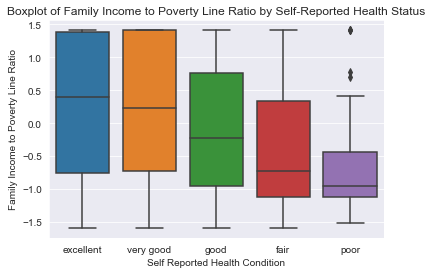

In [7]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

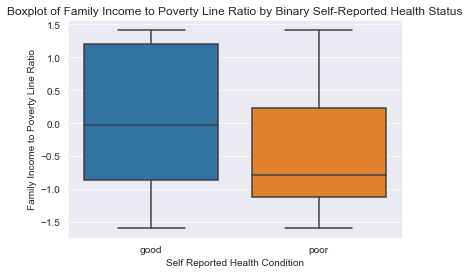

In [8]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

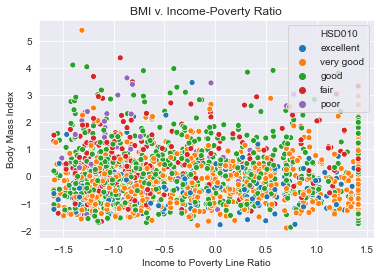

In [9]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [10]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components.
- Plot a barplot of the variation explains by each component.
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA

We first train the PCA using 20 components. This is a large enough number that we expect to see a large portion of the variance in the data explained, but not so large that it is hard to visualize. Given that we only have 2000 or so observations, but 240 features, reducing them to 10-20 components would be ideal in order to avoid the curse of dimensionality. 

In [11]:
X = nhanes_scaled
pca = PCA(n_components=20)
pca_nhanes = pca.fit_transform(X)

### Decide on the Number of Components
We plot the share of the variance explained by each of these components below. As you can see from the intersection of the bars with the horizontal line, components 1-16 each explain over 1% of the variation in the data. There is a quick drop off in share explained after component three. Using the 1% explained as a threshold, we could take the first 16 components.  

In [12]:
# make into data frame with component as one variable and explained ratio as another variable 
var_df = pd.DataFrame({"component": np.array(range(1,21)), "var_ratio" : pca.explained_variance_ratio_})

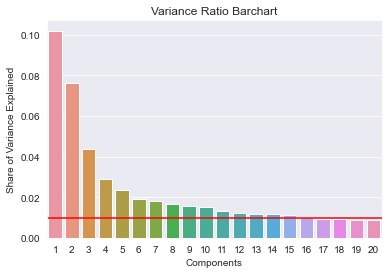

In [13]:
ax = sns.barplot(x="component", y="var_ratio", data=var_df)
ax.set(xlabel = "Components",
      ylabel = "Share of Variance Explained")
ax.set_title("Variance Ratio Barchart")
ax.axhline(0.01, color = 'r')
plt.show()

Another way to think about the number of components to take is to consider the total share of the variation explained. We train the PCA to create the maximum number of components and plot the cummulative variation explained against the number of components. 

In [14]:
pca = PCA()
pca_nhanes = pca.fit_transform(X)

In [15]:
var_df = pd.DataFrame({"component": np.array(range(1,242)), "var_ratio" : pca.explained_variance_ratio_})
# calculate the cummulative variance explained
var_df["cum"] = var_df.cumsum()["var_ratio"]

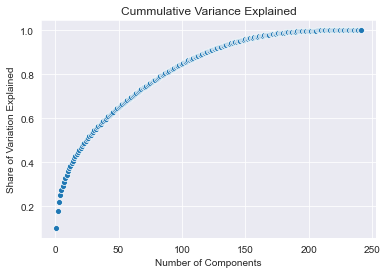

In [16]:
ax = sns.scatterplot(x = "component", y = "cum", data = var_df)
ax.set(xlabel = "Number of Components",
      ylabel = "Share of Variation Explained")
ax.set_title("Cummulative Variance Explained")
plt.show()

The plot above shows that the rate of gain in variation explained starts to fall off pretty quickly (shown by the gradient getting shallower). This is in line with each component after the 16th explaining less than 1% more of the remaining variation. Taking the first 16 components will explain just over 40% of the variation in the data. We think that this is a sufficient share to justify the drastic reduction in dimensions (from 241 to 16).  

In [17]:
#var_df.head(16)

In [18]:
# finalize the PCA
pca = PCA(n_components = 16)
pca_nhanes = pca.fit_transform(X)
var_df = pd.DataFrame({"component": np.array(range(1,17)), "var_ratio" : pca.explained_variance_ratio_})
var_df["cum"] = var_df.cumsum()["var_ratio"]

In [19]:
col_names = ["pc" + str(i) for i in range(1,17)]
pca_df = pd.DataFrame(data = pca_nhanes
    , columns = col_names)

In [20]:
pca_df.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
0,9.527811,-0.816224,-1.867086,-2.109909,-3.929786,-0.185302,-3.844963,-2.941456,1.509333,0.686069,0.118812,2.205196,0.298769,-0.649877,0.430806,-0.687881
1,-5.838339,-3.692573,3.805754,-1.029692,0.394162,1.593954,2.711958,-0.749117,0.377343,-2.406217,-0.437336,1.047860,0.285605,2.422807,0.337891,-1.588025
2,-0.719454,-2.573200,0.907902,-4.755865,-1.799036,0.863525,-1.024815,0.629155,0.540540,0.452672,0.153847,-1.346725,1.717221,-0.226581,0.610268,-0.650714
3,3.533627,-2.576982,-3.249121,-0.405408,3.998762,1.444100,-1.180352,0.317738,-4.153896,-1.236526,-0.786395,2.036713,-2.524099,2.665543,-1.227110,-1.239975
4,-6.872094,-4.194240,0.886824,-0.848934,-0.524412,0.073429,0.842643,0.993118,0.563678,-0.047623,-0.497243,-0.973232,-0.444823,-1.854334,-0.259556,-0.047862


### 2D Scatterplot of the First Two Components
Below we plot the first two principle components and group them based on our target variables - first for the 5-class health outcome and then for the binary health outcome. 

In [21]:
# create data frame for plots

nhanes_pca = pca_df
nhanes_pca["HSD010"] = hsd010
# great binary version too 
nhanes_pca['HSD010_binary'] = hsd010_binary = nhanes_pca['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# recode the original hsd010 with the string labels
nhanes_pca['HSD010'] = nhanes_pca['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])

In [22]:
#nhanes_pca.head()

The plot below shows *some* correspondence between the first two components and our target variable. Specifically, those with "excellent" health have a greater loading **(I THINK THIS IS THE WRONG WORD - I WILL ASK IN OHS)** of PC1 relative to PC2. Additionally, those in the "very good" class have a negative loading of both PC1 and PC2, with more variation in PC1. Similarly, those in the "good" class have a negative loading of both PC1 and PC2, but the magnitude is greater for PC1. It seems like those with "fair" or "poor" health have a more positive loading of PC2, relative to PC1. From this we might conclude that the features loading on to PC1 are those that are correlated with higher self-reported health, while the features that load on to PC2 are more associated with lower self-reported health. 

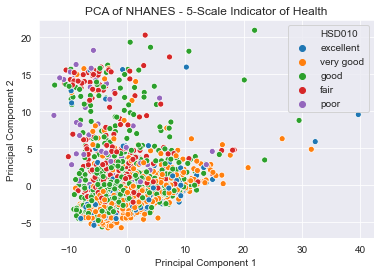

In [23]:
ax = sns.scatterplot(x = "pc1", y = "pc2", hue = "HSD010", palette = "tab10", data = nhanes_pca)
ax.set(xlabel = "Principal Component 1",
      ylabel = "Principal Component 2")
ax.set_title("PCA of NHANES - 5-Scale Indicator of Health")
plt.show()

We can see if this holds when we look at a coarser division of our observations into just two classes, instead of five. Indeed, those with "good" health are more represented by PC1, while those with "poor" health have a higher loading of PC2. Based on both these plots, we think we can be confident that our first two principal components represent meaningful variation in our data. 

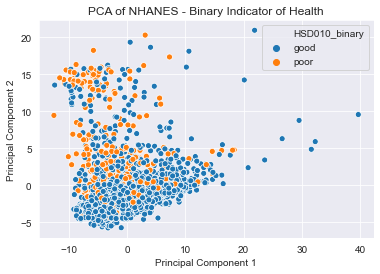

In [24]:
ax = sns.scatterplot(x = "pc1", y = "pc2", hue = "HSD010_binary", palette = "tab10", data = nhanes_pca)
ax.set(xlabel = "Principal Component 1",
      ylabel = "Principal Component 2")
ax.set_title("PCA of NHANES - Binary Indicator of Health")
plt.show()

## K-Means Clustering

K-means clustering is an unsupervised machine learning algorithm. Using a number of clusters, k, selected by the researcher, the algorithm selects observations at random and assigns them as the center of their cluster. Every observation in the dataset is then assigned to whichever of these centers it is nearest to. The algorithm will go through numerous iterations of this procedure until the observations are distributed into clusters that are optimally separated from one another.

In [25]:
X = nhanes_scaled

In [26]:
kmeans = KMeans(init="random", 
                n_clusters=3, 
                n_init=10, 
                max_iter=300, 
                random_state=42)

kmeans.fit(X)

kmeans.inertia_

430160.9829255908

The Sum of Standard Errors (SSE) seems really high, so it's likely that 3 is the wrong number of clusters. Given where we wound up with PCA, at 16 components, the number of clusters should probably be larger. To figure out the optimal number, I'll increment k and look at a plot of the SSEs at each level of k.

In [27]:
kmeans_kwargs = {
    "init": "random", 
    "n_init": 10,
    "max_iter": 300, 
    "random_state": 42,}


sse = []

for k in range(1, 25): 
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs) 
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

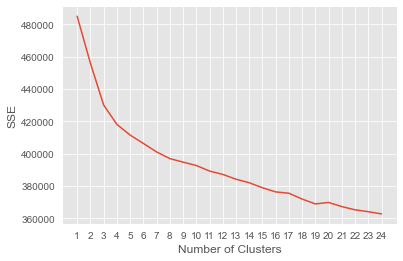

In [28]:
plt.style.use("ggplot")
plt.plot(range(1, 25), sse)
plt.xticks(range(1, 25))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

This elbow plot isn't terribly straightforward. We could reasonably defend using 4 or 8 or 16 or 19. Since eyeballing the number is tricky, I'll use a computational method for optimizing k. 

In [29]:
kl = KneeLocator(
    range(1, 25), sse, curve="convex", direction="decreasing"
)
print("The optimal number of k-means clusters is:", kl.elbow,)
print("But I am just a lowly computer with no domain knowledge for this data.")

The optimal number of k-means clusters is: 5
But I am just a lowly computer with no domain knowledge for this data.


Looking at the PCA plot, 5 looks like a good number of PCA components, too, though it's hard to grasp substantively what these clusters/components mean.

In [30]:
kmeans = KMeans(init="random", 
                n_clusters=5, 
                n_init=10, 
                max_iter=300, 
                random_state=42)

kmeans.fit(X)

print("Centers")
print(kmeans.cluster_centers_)
print()

print("Labels")
print(kmeans.labels_)
print()

#for point, label in zip(X, kmeans.labels_):
#    print("Coordinates:", point, "Label:", label)
    
#print(kmeans.n_iter_)

Centers
[[ 0.         -0.12193824  0.         ...  0.29069365  0.27076969
   0.61244043]
 [ 0.          0.00476192  0.         ...  0.01947413 -0.05107832
  -1.14582792]
 [ 0.          0.04099232  0.         ... -0.11366741 -0.21269441
   0.24722966]
 [ 0.          0.00712832  0.         ... -0.01194631 -0.05862467
   0.0362778 ]
 [ 0.         -0.04433151  0.         ...  0.09571445  0.38744673
   0.56915846]]

Labels
[3 1 1 ... 1 3 2]



### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [31]:
# limit X to the features we want (BMI and Income) and convert to array
bmi_inc = X[["BMXBMI", "INDFMPIR"]].values

In [32]:
# find the k-means centers for these features 
kmeans.cluster_centers_.shape
bmi_loc = X.columns.get_loc("BMXBMI")
inc_loc = X.columns.get_loc("INDFMPIR")
centers = kmeans.cluster_centers_[:,[bmi_loc, inc_loc]]
centers.shape

(5, 2)

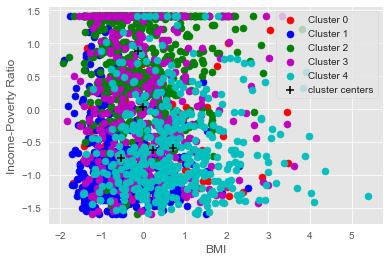

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(*bmi_inc[kmeans.labels_==0,:].T, s=50, c='r', label='Cluster 0')
ax1.scatter(*bmi_inc[kmeans.labels_==1,:].T, s=50, c='b', label='Cluster 1')
ax1.scatter(*bmi_inc[kmeans.labels_==2,:].T, s=50, c='g', label='Cluster 2')
ax1.scatter(*bmi_inc[kmeans.labels_==3,:].T, s=50, c='m', label='Cluster 3')
ax1.scatter(*bmi_inc[kmeans.labels_==4,:].T, s=50, c='c', label='Cluster 4')

ax1.scatter(*centers.T, s=50, marker='+', c='black', label='cluster centers')
plt.legend(loc='upper right')
plt.xlabel('BMI')
plt.ylabel('Income-Poverty Ratio')
plt.show()

### Retraining the clustering algorithm on PCA components and plotting clusters on a 2D scatter

In [34]:
# Train the k means algorithm on the PCA components
kmeans_pca= KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)

kmeans_pca.fit(pca_nhanes)

KMeans(n_clusters=5, random_state=42)

In [35]:
# Creat a data frame that includes the original data + PCA scores + clusters
combo_df = pd.concat([nhanes_scaled.reset_index(drop = True), pd.DataFrame(pca_nhanes)], axis = 1)
combo_df.columns.values[-16: ] = ["Component_1", "Component_2", "Component_3", "Component_4", "Component_5", "Component_6", "Component_7", "Component_8", "Component_9", "Component_10", "Component_11", "Component_12", "Component_13", "Component_14", "Component_15", "Component_16"]
combo_df['cluster_pca_km'] = kmeans_pca.labels_

combo_df['cluster'] = combo_df['cluster_pca_km'].map({0:'first', 1: 'second', 2: 'third', 3: 'fourth', 4: 'fifth'})


Text(0, 0.5, 'Income to Poverty Ratio')

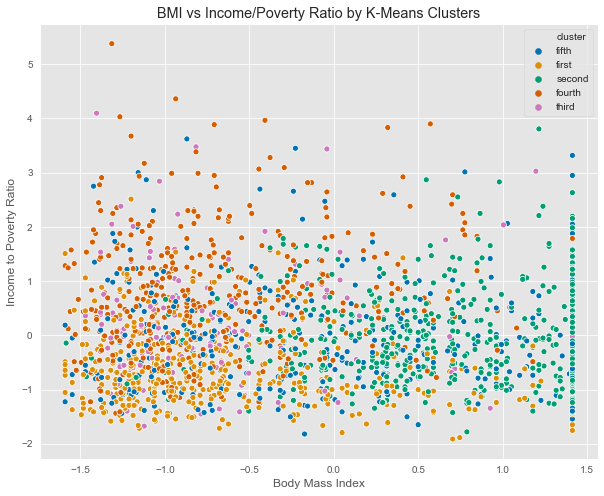

In [36]:
# plot the clusters onto BMI vs Income Ratio
x_axis = combo_df["INDFMPIR"]
y_axis = combo_df["BMXBMI"]
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue = combo_df["cluster"], palette = 'colorblind')
plt.title("BMI vs Income/Poverty Ratio by K-Means Clusters")

plt.xlabel("Body Mass Index")
plt.ylabel("Income to Poverty Ratio")

Text(0.5, 1.0, 'PCA 1 Plotted Against PCA 2 with K-Means Clusters')

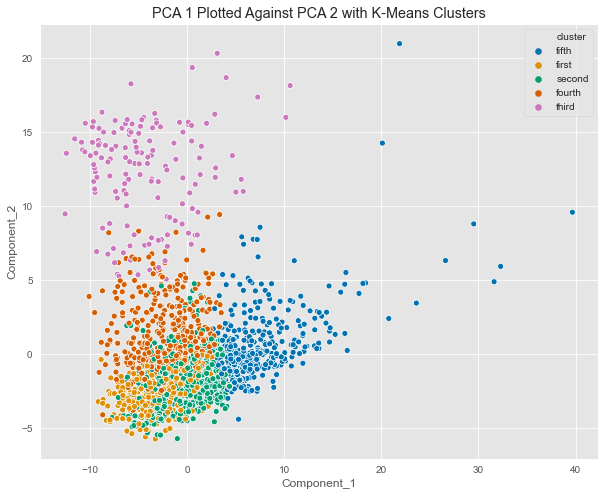

In [37]:
# plot the clusters onto the first 2 PCA components
x_axis = combo_df["Component_1"]
y_axis = combo_df["Component_2"]
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue = combo_df["cluster"], palette = 'colorblind')
plt.title("PCA 1 Plotted Against PCA 2 with K-Means Clusters")

The clusters map nicely onto the first two principal components, while the clusters don't seem to tell us much when plotted over BMI/Income-poverty ratio. One exception is that we can see a clear separation in the BMI plot between the yellow and green clusters. This same separation appears in the PCA plot, indicating that perhaps the difference in health status for these two groups is related to BMI, or related to the underlying factors that are also driving differences in BMI.

Looking at the PCA-Cluster plot, we wonder if the pink cluster might indicate individuals who are elderly, given that they appear to have poorer health but widely dispered across both Income/Poverty and BMI.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [38]:
y = hsd010  # either hsd010 or hsd010_binary  # just put the outcome variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [39]:
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812


In [40]:
# drop target variable from x (sequence variable and target variable should be dropped)

In [41]:
num_classes=6
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical (y_test, num_classes) 

In [42]:
#num_classes =
#num_classes = ...
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(..., ...)
#y_test = keras.utils.to_categorical(..., ...)
#num_classes = y_test.shape[1]
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical (y_test, num_classes) 

In [43]:
print(y_train[0])

num_classes = y_test.shape[1]
num_classes

[0. 1. 0. 0. 0. 0.]


6

In [44]:
#_train.shape
num_obs = X_train.shape[0] * X_train.shape[1]
num_obs

373068

In [45]:
model = Sequential()

In [ ]:
# input layer
model.add(
    Dense(num_obs, input_dim=num_obs, kernel_initializer='normal', activation='relu')
)

In [1]:
#output layer
model.add(
    Dense(num_classes, kernel_initializer='normal', activation='softmax')
)

NameError: name 'model' is not defined

In [ ]:
#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=200, verbose=2)

### Neural Network on Principal Components

In [ ]:
## Your Answer Here

### Neural Network on Principal Components + Cluster Membership

In [ ]:
## Your Answer Here

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA is helpful for reducing the number of features in a dataset, while clustering is helpful for reducing the number of observations. 

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

In [ ]:
## Your Answer Here